In [1]:
# https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

from statsmodels.tsa.api import ExponentialSmoothing
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
df_dates=pd.read_csv("date_orders.csv",header=None)
df_dates.columns=["Date Received","Order Number"]
df_date=pd.DataFrame(df_dates.groupby(["Date Received"])["Order Number"].sum())

df_date.to_csv("date_orders_sum.csv")

In [3]:
df_date=pd.read_csv("date_orders_sum.csv")
df_date['Date Received'] =  pd.to_datetime(df_date['Date Received'], format='%m/%d/%Y')
df_date = df_date.sort_values(by=['Date Received'], ascending=[True])

# Fill the gab in datestamp and assign na to zero
r= pd.date_range(start=df_date['Date Received'] .min(), end=df_date['Date Received'].max())
df_date_new=df_date.set_index('Date Received').reindex(r).fillna(0.0).rename_axis('Date Received').reset_index()

df_date=df_date_new
# data.set_index('Date Received', inplace=True)

In [4]:
df_date[1459:]

,Date Received,Order Number
1459,2020-01-01,0.0
1460,2020-01-02,20.0
1461,2020-01-03,8.0
1462,2020-01-04,0.0
1463,2020-01-05,0.0
...,...,...
1541,2020-03-23,43.0
1542,2020-03-24,4.0
1543,2020-03-25,9.0
1544,2020-03-26,36.0


In [5]:
#Subsetting the dataset
#Index 1225 marks the end of year 2013
df = df_date
df.columns=["Datetime","Count"]
#Creating train and test set 
#Index 10marks the end of October 2013 
train=df[0:1458] 
test=df[1459:]

#Aggregating the dataset at daily level
df.Timestamp = pd.to_datetime(df.Datetime,format='%m/%d/%Y') 
df.index = df.Timestamp 
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%m/%d/%Y') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test.Datetime,format='%m/%d/%Y') 
test.index = test.Timestamp 
test = test.resample('D').mean()

C:\Users\h313123\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()
C:\Users\h313123\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
C:\Users\h313123\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


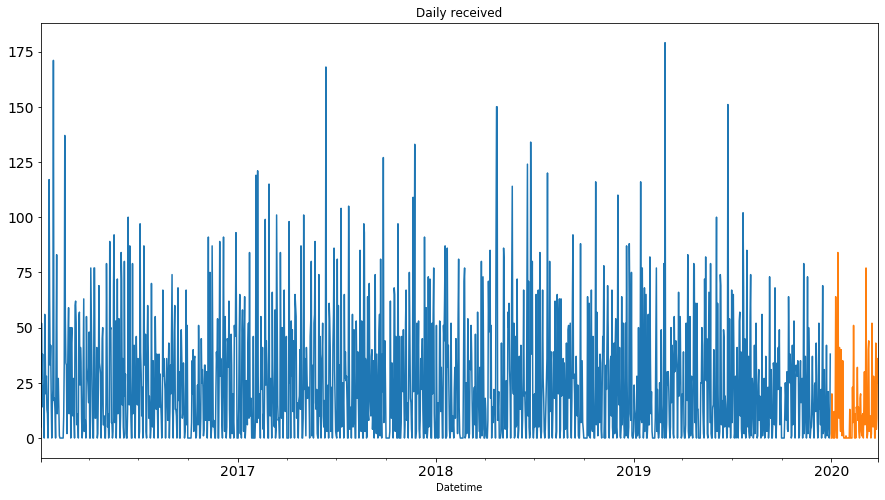

In [6]:
#Plotting data
train.Count.plot(figsize=(15,8), title= 'Daily received', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily received', fontsize=14)
plt.show()

### Method 1: Start with a Naive Approach




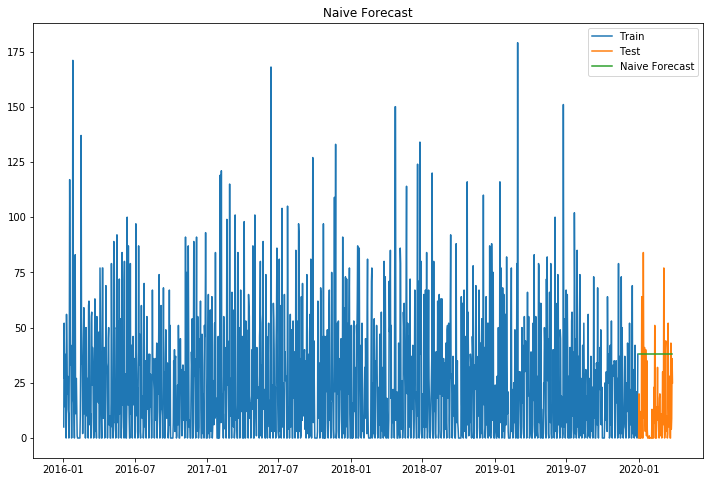

In [7]:
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)

30.359342139980797


### Method 2: – Simple Average

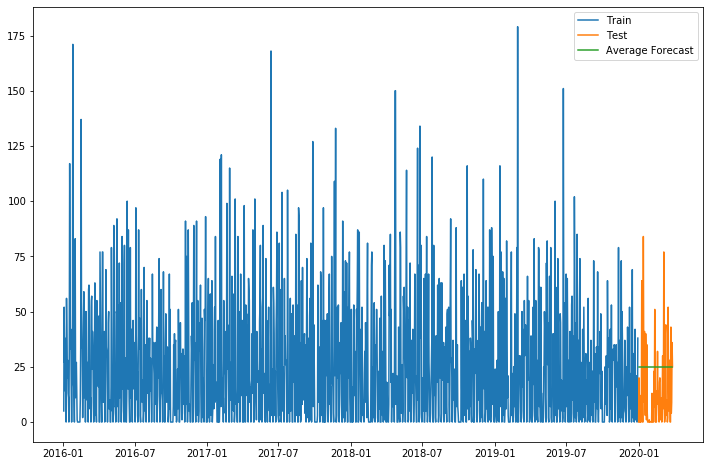

In [9]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [10]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.avg_forecast))
print(rms)

21.309792537073204


### Method 3 – Moving Average


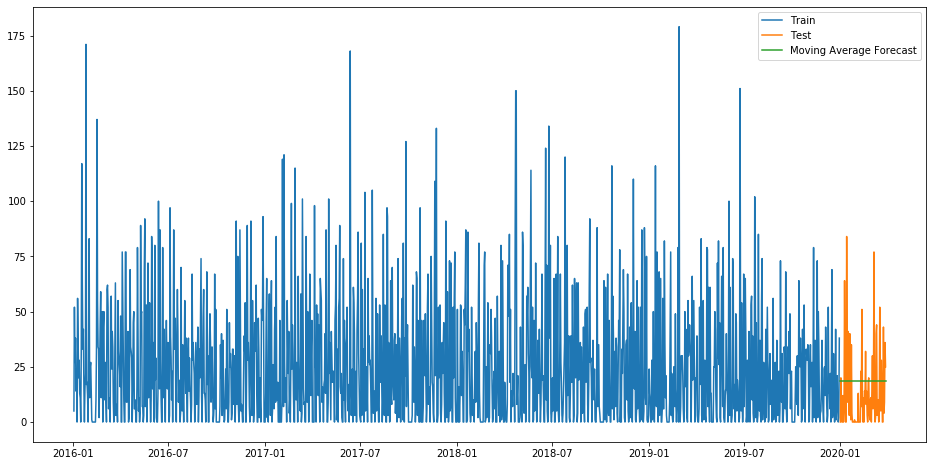

In [11]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [12]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.moving_avg_forecast))
print(rms)

18.664306090478703


### Method 4 – Simple Exponential Smoothing

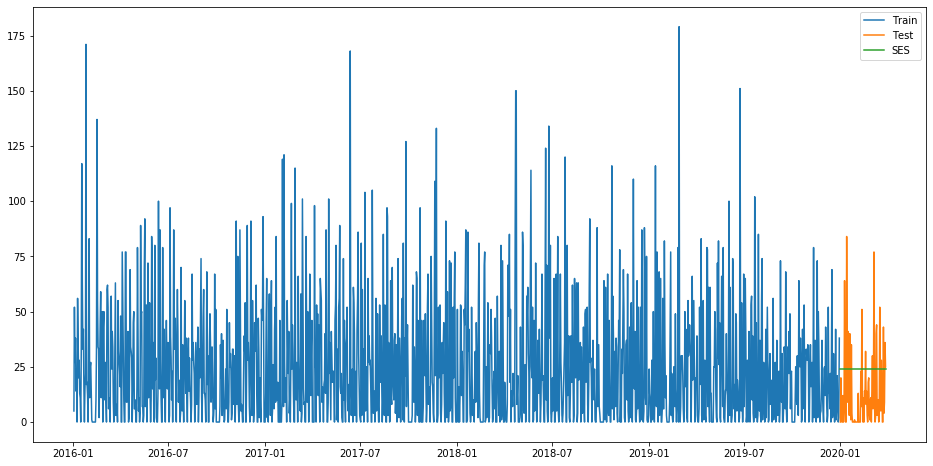

In [13]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [14]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SES))
print(rms)

20.75142509461492


### Method 5 – Holt’s Linear Trend method

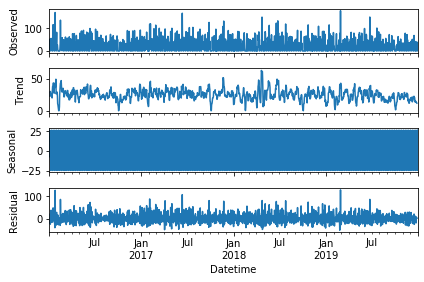

In [15]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

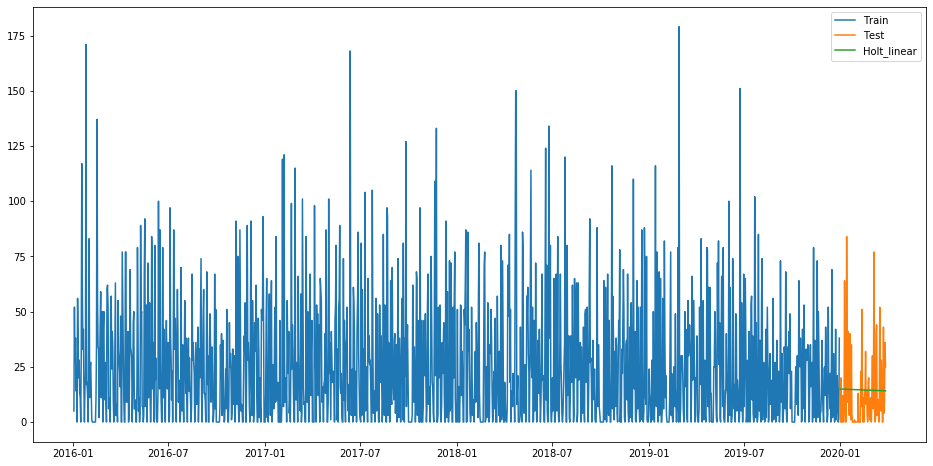

In [16]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [76]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_linear))
print(rms)

17.985397833906628


### Method 6 – Holt-Winters Method

C:\Users\h313123\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


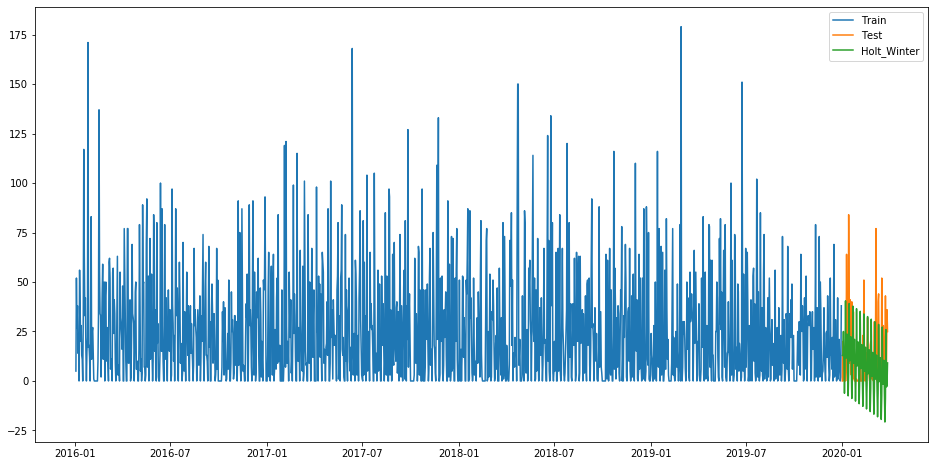

In [19]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [20]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_Winter))
print(rms)

23.670017038802087
